In [12]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap

## What is this an image of?   

![pic](traffic_visual.jpeg)

 

## Data Science 

This is actually a growing field on its own and as we've seen touches all our lives. It's called Data Science. This field attempts to look at the large amounts of data humans are able to create on a daily basis. When we analyze this data we can learn interesting things about ourselves and even the world around us. 

* What kinds of things could we learn from Data Science? 

## Hurricanes in the Atlantic

Today we're going to use visualize hurricanes by using a historical tracks of hurricanes in the Atlantic ocean since 1950. Take a look at our dataset [here](https://raw.githubusercontent.com/applied-math/demos/master/hurdat.txt). 

## Coding 

What's the first thing we need? 

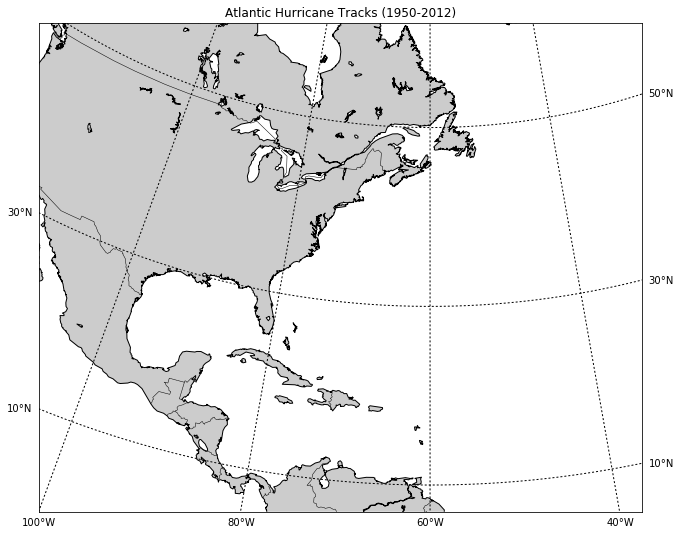

In [13]:
fig = plt.figure(figsize=(15,9))
axes = fig.add_subplot(1, 1, 1)
mapping = Basemap(llcrnrlon=-100.0, llcrnrlat=0.0, urcrnrlon=-20.0, urcrnrlat=57.0,
                  projection='lcc', lat_1=20.0, lat_2=40.0, lon_0=-60.0,
                  resolution ='l', area_thresh=1000.0)

mapping.drawcoastlines()
mapping.drawcountries()
mapping.fillcontinents()
mapping.drawparallels(numpy.arange(10,70,20), labels=[1,1,0,0])
mapping.drawmeridians(numpy.arange(-100,0,20), labels=[0,0,0,1])
axes.set_title('Atlantic Hurricane Tracks (1950-2012)')
plt.show()

Play around with the code. Here some questions to help you get started. 
* What happens when you delete mapping.drawcoastlines() from the map? 
* What happens when you change the fig size? 

## Loading Data 

We need to load the data first if we want to visualize the hurricane's paths. 

In [17]:
# Load data
hurricanes = {}
current_name = None
num_hurricanes = numpy.zeros(63, dtype=int)
cache = [[], [], [], [], [], [], [], [], []]

with open("hurdat.txt", 'r') as hurdat_data:
    for line in hurdat_data:
        split_data = line.split()
        year = int(split_data[0])
        month = int(split_data[1])
        day = int(split_data[2])
        hour = int(split_data[3])
        if split_data[5] == "NOT" and split_data[6] == "NAMED":
            pass
        else:
            name = split_data[5]
            lat = float(split_data[6])
            lon = float(split_data[7])
            wind_speed = float(split_data[8])
            pressure = float(split_data[9])
        
            # Categorize hurricanes (wind speed in knots)
            if wind_speed >= 64 and wind_speed < 83:
                category = 1
            elif wind_speed >= 83 and wind_speed < 96:
                category = 2
            elif wind_speed >= 96 and wind_speed < 113:
                category = 3
            elif wind_speed >= 113 and wind_speed < 135:
                category = 4
            elif wind_speed >= 135:
                category = 5
            else:
                category = 0
        
            if name != current_name:
                hurricanes[current_name] = {'year':cache[0][:], 
                                            'month':cache[1][:], 
                                            'day':cache[2][:], 
                                            'hour':cache[3][:], 
                                            'latitude':cache[4][:], 
                                            'longitude':cache[5][:], 
                                            'wind speed':cache[6][:], 
                                            'pressure':cache[7][:], 
                                            'category':cache[8][:]}
                cache = [[], [], [], [], [], [], [], [], []]
                current_name = name

                # Count huricanes
                num_hurricanes[year - 1950] +=  1

            cache[0].append(year)
            cache[1].append(month)
            cache[2].append(day)
            cache[3].append(hour)
            cache[4].append(lat)
            cache[5].append(lon)
            cache[6].append(wind_speed)
            cache[7].append(pressure)
            cache[8].append(category)
            
# Remove empty hurricanes
for name in hurricanes.keys():
    if len(hurricanes[name]['year']) == 0:
        data = hurricanes.pop(name)





#### Now let's plot the data onto the map. 






/Users/hudaqureshi/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/hudaqureshi/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


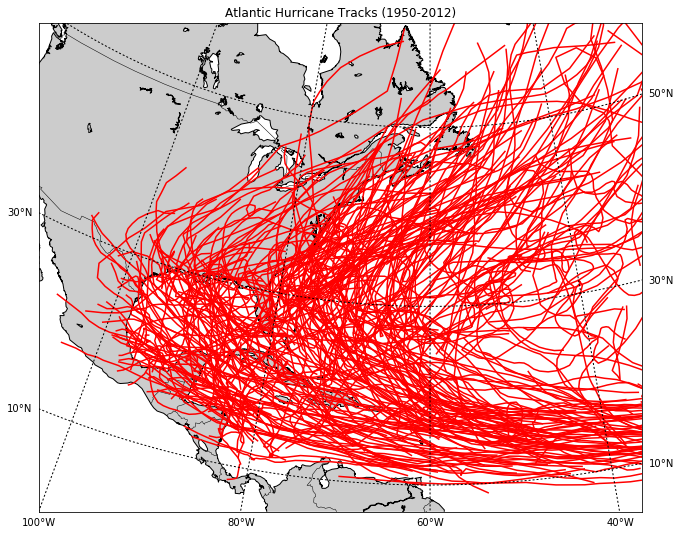

In [18]:
# Plot the data
category_color = {5:'red', 4:'yellow', 3:'orange', 2:'green', 1:'blue', 0:'gray'}
fig = plt.figure(figsize=(15,9))
axes = fig.add_subplot(1, 1, 1)
mapping = Basemap(llcrnrlon=-100.0, llcrnrlat=0.0, urcrnrlon=-20.0, urcrnrlat=57.0,
                  projection='lcc', lat_1=20.0, lat_2=40.0, lon_0=-60.0,
                  resolution ='l', area_thresh=1000.0)

for (name, data) in hurricanes.iteritems():
    longitude, latitude = mapping(data['longitude'], data['latitude'])
    mapping.plot(longitude, latitude, linewidth=1.5, color='r')

mapping.drawcoastlines()
mapping.drawcountries()
mapping.fillcontinents()
mapping.drawparallels(numpy.arange(10,70,20), labels=[1,1,0,0])
mapping.drawmeridians(numpy.arange(-100,0,20), labels=[0,0,0,1])
axes.set_title('Atlantic Hurricane Tracks (1950-2012)')
plt.show()

In [ ]:
# Plot the data
category_color = {5:'red', 4:'yellow', 3:'orange', 2:'green', 1:'blue', 0:'gray'}
fig = plt.figure(figsize=(15,9))
axes = fig.add_subplot(1, 1, 1)
mapping = Basemap(llcrnrlon=-100.0, llcrnrlat=0.0, urcrnrlon=-20.0, urcrnrlat=57.0,
                  projection='lcc', lat_1=20.0, lat_2=40.0, lon_0=-60.0,
                  resolution ='l', area_thresh=1000.0)

for (name, data) in hurricanes.iteritems():
    longitude, latitude = mapping(data['longitude'], data['latitude'])
    for i in xrange(len(longitude) - 1):
        color = category_color[data['category'][i]]
        mapping.plot(longitude[i:i+2], latitude[i:i+2], linewidth=1.5, color=color)

mapping.drawcoastlines()
mapping.drawcountries()
mapping.fillcontinents()
mapping.drawparallels(numpy.arange(10,70,20), labels=[1,1,0,0])
mapping.drawmeridians(numpy.arange(-100,0,20), labels=[0,0,0,1])
axes.set_title('Atlantic Hurricane Tracks (1950-2012)')
for (category, color) in category_color.iteritems():
    axes.plot([0], [0], color=color, label="Category %s" % category)
axes.legend(loc=2)
plt.show()

The data is still pretty hard to discern as it looks like colorful spaghetti.  We can ask more specific questions such as 
 - Which storms happened in 2010?
 - What storms were category 3 or above?
 - Where did Hurricane Sandy go?

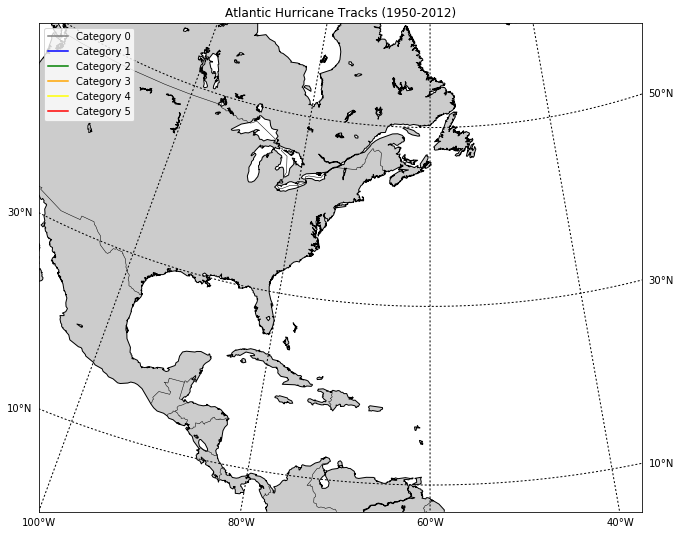

In [19]:
# Plot the data
category_color = {5:'red', 4:'yellow', 3:'orange', 2:'green', 1:'blue', 0:'gray'}
fig = plt.figure(figsize=(15,9))
axes = fig.add_subplot(1, 1, 1)
mapping = Basemap(llcrnrlon=-100.0, llcrnrlat=0.0, urcrnrlon=-20.0, urcrnrlat=57.0,
                  projection='lcc', lat_1=20.0, lat_2=40.0, lon_0=-60.0,
                  resolution ='l', area_thresh=1000.0)

for (name, data) in hurricanes.iteritems():
    if data['year'][0] == 2011 and numpy.any(numpy.array(data['category']) >= 3):
        if name == "KATRINA":
            longitude, latitude = mapping(data['longitude'], data['latitude'])
            for i in xrange(len(longitude) - 1):
                color = category_color[data['category'][i]]
                mapping.plot(longitude[i:i+2], latitude[i:i+2], linewidth=1.5, color=color)

mapping.drawcoastlines()
mapping.drawcountries()
mapping.fillcontinents()
mapping.drawparallels(numpy.arange(10,70,20), labels=[1,1,0,0])
mapping.drawmeridians(numpy.arange(-100,0,20), labels=[0,0,0,1])
axes.set_title('Atlantic Hurricane Tracks (1950-2012)')
for (category, color) in category_color.iteritems():
    axes.plot([0], [0], color=color, label="Category %s" % category)
axes.legend(loc=2)
plt.show()

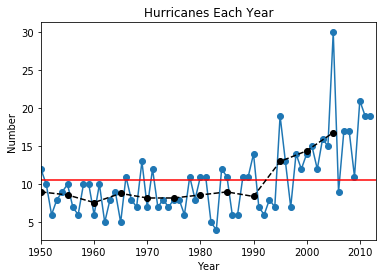

In [12]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(range(1950, 2013, 1), num_hurricanes, 'o-')
axes.plot((1950, 2013), (num_hurricanes.mean(), num_hurricanes.mean()), 'r')


# Compute rolling average
num_hurricanes_mean = numpy.zeros(12)
for i in xrange(0,60,5):
    num_hurricanes_mean[i/5] = num_hurricanes[i:i+5].mean()
    
    
axes.plot(range(1950, 2010, 5), num_hurricanes_mean, 'ko--')
axes.set_xlim((1950, 2013))
axes.set_title("Hurricanes Each Year")
axes.set_xlabel("Year")
axes.set_ylabel("Number")
plt.show()

## Recap 

* What did we learn to do today? 
* What are some issues that came up? 
* Below are some more datasets. Take a look and see what kinds of questions you can come up that you want to explore? 

[The **C**ollection of **R**eally **G**reat, **I**nteresting, **S**ituated **D**atasets](https://think.cs.vt.edu/corgis/python/index.html)